In [5]:
import graphlab as gl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline


#### Getting the Data

In [6]:
import os
print(os.path.abspath(os.curdir))

/Users/sunilayyappan/DSProjects/MIT/Movies


#### Next, we want to load this data, setting the column names and dropping the timestamp.

In [7]:
col_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_table('u.data', names=col_names)
data = data.drop('timestamp', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
user_id    100000 non-null int64
item_id    100000 non-null int64
rating     100000 non-null int64
dtypes: int64(3)
memory usage: 2.3 MB


#### For instance, we can plot the distribution of ratings with a histogram.


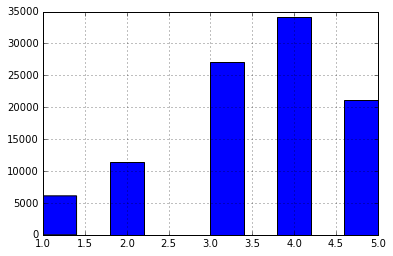

In [8]:
data.rating.hist()
plt.show()

#### Working With the Dataset
We can compute the sparsity with the formula provided in the Case Study documentation.

In [9]:
num_ratings = float(len(data))
num_movies = float(len(np.unique(data["item_id"])))
num_users = float(len(np.unique(data["user_id"])))
sparsity = (num_ratings / (num_movies * num_users)) * 100.0
print "Sparsity of Dataset is", sparsity, "Percent"

Sparsity of Dataset is 6.30466936422 Percent


#### Data Partitions
If you want the data to be less sparse, for example, a good way to achieve that is to subset the data where you only select Users/Movies that have at least a certain number of observations in the dataset. The criteria we are currently using is to not include a user if they have fewer than 50 ratings. This value can be changed in the RATINGS_CUTOFF variable.

In [10]:
# Get the column containing the users
users = data.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [11]:
# We want our users to have at least 50 ratings to be considred
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.iteritems():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
data = data.loc[~data.user_id.isin(remove_users)]

Now, we can recalculate the sparsity as we did earlier.

In [12]:
num_ratings = float(len(data))
num_movies = float(len(np.unique(data["item_id"])))
num_users = float(len(np.unique(data["user_id"])))
sparsity = (num_ratings / (num_movies * num_users)) * 100.0
print "UPDATED Sparsity of Dataset is", sparsity, "Percent"

UPDATED Sparsity of Dataset is 9.26584192843 Percent


#### Integrating a Popularity Recommender

Now, we must convert our data to a graphlab SFrame object so we can begin to use it for our recommendation engines.

In [13]:
sf = gl.SFrame(data)

#### Train/Test/Validation Split
We must now subset the data into train, validation, and test sets to use for our different models. First, we split the entire dataset into 70% train and 30% test. Then, we further split the train set into 75% train and 25% val.


In [14]:
sf_train, sf_test = sf.random_split(.70)

In [15]:
sf_train, sf_validate = sf_train.random_split(.75)

#### Now, we can use graphlab's easy to use popularity recommender to train on our training set and examine the RMSE on the test data.

In [16]:
popularity_recommender = gl.recommender.popularity_recommender.create(sf_train, target='rating')
popularity_recommender.evaluate_rmse(sf_test, 'rating')

Recsys training: model = popularity

Preparing data set.

Data has 46369 observations with 568 users and 1589 items.

Data prepared in: 0.09649s

46369 observations to process; with 1589 unique items.

{'rmse_by_item': Columns:
 	item_id	int
 	count	int
 	rmse	float
 
 Rows: 1493
 
 Data:
 +---------+-------+----------------+
 | item_id | count |      rmse      |
 +---------+-------+----------------+
 |   118   |   71  | 1.10295576472  |
 |   1029  |   4   | 1.82002747232  |
 |   435   |   65  | 0.729386413774 |
 |   1517  |   2   |  2.2360679775  |
 |   537   |   11  | 1.31739788602  |
 |   526   |   41  | 0.970896971013 |
 |   232   |   32  | 1.11088192081  |
 |   310   |   29  | 0.84749319617  |
 |    49   |   29  | 0.870265060504 |
 |    13   |   50  | 1.07414036019  |
 +---------+-------+----------------+
 [1493 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	user_id	int
 	count	int
 	rmse	float
 
 Rows: 568
 
 Data:
 +---------+-------+----------------+
 | user_id | count |      rmse      |
 +---------+-------+----------------+
 |   118   |   18  | 1.

####  Integrating a Collaborative Filtering Recommender

For collaborative filtering, we will use graphlab's Factorization Recommender model. We initialize the model with the training data and use the validation data to determine the best regularization term to use.

In [17]:
# We will try regularization terms in the range [10**-5, 10**-1]
regularization_terms = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1]
# We want to keep track of our best results as we go
best_regularization_term = 0
best_RMSE = np.inf
for regularization_term in regularization_terms:
    # Train with this reg term
    factorization_recommender = gl.recommender.factorization_recommender.create(sf_train,
                                                                                target='rating',
                                                                                regularization=regularization_term)
    # Evaluate on our validation set (NOT test set yet)
    evaluation = factorization_recommender.evaluate_rmse(sf_validate, 'rating')
    # See if we found the best score yet
    if evaluation['rmse_overall'] < best_RMSE:
        best_RMSE = evaluation['rmse_overall']
        best_regularization_term = regularization_term

print "Best Regularization Term", best_regularization_term
print "Best Validation RMSE Achieved", best_RMSE

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46369 observations with 568 users and 1589 items.

Data prepared in: 0.131187s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-05    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46369 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 0.711127                                 |

| 5       | 0.0488281         | 0.731752                                 |

| 6       | 0.0244141         | 0.773561                                 |

| 7       | 0.012207          | 0.836503                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 0.711127                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 114us        | 1.26161           | 1.12321               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 94.034ms     | 1.07428           | 1.03646               | 0.0976562   |

| 2       | 185.706ms    | 0.943942          | 0.971084              | 0.0580668   |

| 3       | 255.291ms    | 0.867498          | 0.929926              | 0.042841    |

| 4       | 331.08ms     | 0.817333          | 0.901503              | 0.0345267   |

| 5       | 415.021ms    | 0.763727          | 0.869876              | 0.029206    |

| 6       | 577.991ms    | 0.709664          | 0.836663              | 0.0254734   |

| 11      | 1.03s        | 0.557538          | 0.733987              | 0.016168    |

| 25      | 2.22s        | 0.47524           | 0.669056              | 0.00873464  |

| 50      | 4.42s        | 0.446616          | 0.643453              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.423941

Final training RMSE: 0.625585

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46369 observations with 568 users and 1589 items.

Data prepared in: 0.084844s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46369 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 15.8779           | Not Viable                               |

| 1       | 3.96947           | Not Viable                               |

| 2       | 0.992368          | Not Viable                               |

| 3       | 0.248092          | 0.453345                                 |

| 4       | 0.124046          | 0.700773                                 |

| 5       | 0.062023          | 0.70858                                  |

| 6       | 0.0310115         | 0.742769                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.248092          | 0.453345                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 111us        | 1.2616            | 1.12321               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 188.746ms    | DIVERGED          | DIVERGED              | 0.248092    |

| RESET   | 205.284ms    | 1.2616            | 1.12321               |             |

| 1       | 300.178ms    | DIVERGED          | DIVERGED              | 0.124046    |

| RESET   | 303.43ms     | 1.26163           | 1.12322               |             |

| 1       | 379.182ms    | 1.00114           | 1.00057               | 0.062023    |

| 2       | 465.993ms    | 0.904703          | 0.951156              | 0.0368791   |

| 3       | 551.749ms    | 0.874967          | 0.935375              | 0.027209    |

| 4       | 670.729ms    | 0.861712          | 0.928115              | 0.0219285   |

| 5       | 770.232ms    | 0.849618          | 0.920871              | 0.0185492   |

| 6       | 851.769ms    | 0.83889           | 0.912962              | 0.0161785   |

| 11      | 1.21s        | 0.782805          | 0.868666              | 0.0102685   |

| 23      | 2.32s        | 0.702072          | 0.787883              | 0.00590551  |

| 48      | 4.13s        | 0.647323          | 0.702483              | 0.00340112  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.634498

Final training RMSE: 0.691158

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46369 observations with 568 users and 1589 items.

Data prepared in: 0.075498s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46369 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.58779           | Not Viable                               |

| 1       | 0.396947          | Not Viable                               |

| 2       | 0.0992368         | 0.724921                                 |

| 3       | 0.0496184         | 0.750559                                 |

| 4       | 0.0248092         | 0.785175                                 |

| 5       | 0.0124046         | 0.831663                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0992368         | 0.724921                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 91us         | 1.26159           | 1.12321               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 112.483ms    | DIVERGED          | DIVERGED              | 0.0992368   |

| RESET   | 119.72ms     | 1.2616            | 1.12321               |             |

| 1       | 250.897ms    | DIVERGED          | DIVERGED              | 0.0496184   |

| RESET   | 262.835ms    | 1.2616            | 1.12321               |             |

| 1       | 371.627ms    | 0.97168           | 0.985737              | 0.0248092   |

| 2       | 484.977ms    | 0.86997           | 0.932721              | 0.0115371   |

| 3       | 565.11ms     | 0.847767          | 0.920742              | 0.00751622  |

| 4       | 687.245ms    | 0.838798          | 0.915859              | 0.00557368  |

| 5       | 764.938ms    | 0.832862          | 0.912613              | 0.00442902  |

| 6       | 902.268ms    | 0.829145          | 0.910574              | 0.00367441  |

| 11      | 1.33s        | 0.820811          | 0.905986              | 0.00198414  |

| 23      | 2.30s        | 0.814755          | 0.902638              | 0.000943018 |

| 48      | 4.09s        | 0.811326          | 0.900736              | 0.000450521 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.809779

Final training RMSE: 0.899877

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46369 observations with 568 users and 1589 items.

Data prepared in: 0.098749s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46369 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.158779          | Not Viable                               |

| 1       | 0.0396947         | Not Viable                               |

| 2       | 0.00992368        | 0.942618                                 |

| 3       | 0.00496184        | 1.01173                                  |

| 4       | 0.00248092        | 1.07182                                  |

| 5       | 0.00124046        | 1.12671                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00992368        | 0.942618                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 97us         | 1.2616            | 1.12321               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 126.785ms    | DIVERGED          | DIVERGED              | 0.00992368  |

| RESET   | 195.744ms    | 1.2616            | 1.12321               |             |

| 1       | 497.775ms    | 1.06387           | 1.03144               | 0.00496184  |

| 2       | 793.764ms    | 0.942108          | 0.970622              | 0.00150324  |

| 3       | 982.242ms    | 0.9225            | 0.960468              | 0.000885804 |

| 4       | 1.13s        | 0.91286           | 0.955437              | 0.000627901 |

| 5       | 1.38s        | 0.906772          | 0.952246              | 0.000486311 |

| 6       | 1.56s        | 0.902416          | 0.949956              | 0.000396827 |

| 9       | 2.17s        | 0.894236          | 0.945641              | 0.000255685 |

| 11      | 2.34s        | 0.890762          | 0.943802              | 0.000206678 |

| 14      | 2.99s        | 0.886973          | 0.941792              | 0.000160526 |

| 19      | 3.61s        | 0.882673          | 0.939507              | 0.000116987 |

| 24      | 4.45s        | 0.879694          | 0.93792               | 9.20267e-05 |

| 29      | 5.10s        | 0.877449          | 0.936723              | 7.58446e-05 |

| 34      | 5.75s        | 0.875665          | 0.93577               | 6.45024e-05 |

| 39      | 6.45s        | 0.874196          | 0.934984              | 5.61112e-05 |

| 44      | 7.07s        | 0.872953          | 0.934319              | 4.96519e-05 |

| 49      | 7.83s        | 0.87188           | 0.933745              | 4.45263e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.871434

Final training RMSE: 0.933506

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46369 observations with 568 users and 1589 items.

Data prepared in: 0.158977s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46369 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0158779         | Not Viable                               |

| 1       | 0.00396947        | 1.07721                                  |

| 2       | 0.00198474        | 1.13913                                  |

| 3       | 0.000992368       | 1.17853                                  |

| 4       | 0.000496184       | 1.20199                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00396947        | 1.07721                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 1.2616            | 1.12321               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 376.545ms    | DIVERGED          | DIVERGED              | 0.00396947  |

| RESET   | 408.836ms    | 1.2616            | 1.12321               |             |

| 1       | 583.289ms    | DIVERGED          | DIVERGED              | 0.00198474  |

| RESET   | 591.118ms    | 1.26162           | 1.12322               |             |

| 1       | 787.832ms    | 1.18925           | 1.09053               | 0.000992368 |

| 2       | 954.758ms    | 1.11621           | 1.05651               | 0.000177161 |

| 3       | 1.04s        | 1.10364           | 1.05054               | 9.72622e-05 |

| 4       | 1.28s        | 1.09667           | 1.04722               | 6.70314e-05 |

| 5       | 1.40s        | 1.09187           | 1.04493               | 5.11371e-05 |

| 6       | 1.50s        | 1.08824           | 1.04319               | 4.13357e-05 |

| 8       | 1.85s        | 1.0829            | 1.04062               | 2.98811e-05 |

| 11      | 2.10s        | 1.07742           | 1.03799               | 2.11074e-05 |

| 18      | 2.78s        | 1.06961           | 1.03422               | 1.25258e-05 |

| 28      | 3.91s        | 1.06313           | 1.03108               | 7.92368e-06 |

| 38      | 4.69s        | 1.05889           | 1.02903               | 5.79465e-06 |

| 48      | 5.43s        | 1.05576           | 1.0275                | 4.56742e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.05508

Final training RMSE: 1.02717

Best Regularization Term 0.001
Best Validation RMSE Achieved 0.945928100515


Now that we know the best parameter, we can use it to evaluate on our TEST set!

In [18]:
factorization_recommender = gl.recommender.factorization_recommender.create(sf_train,
                                                                            target='rating',
                                                                            regularization=best_regularization_term)
print "Test RMSE on best model", factorization_recommender.evaluate_rmse(sf_test, 'rating')['rmse_overall']

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46369 observations with 568 users and 1589 items.

Data prepared in: 0.083679s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46369 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.58779           | Not Viable                               |

| 1       | 0.396947          | Not Viable                               |

| 2       | 0.0992368         | 0.727038                                 |

| 3       | 0.0496184         | 0.750904                                 |

| 4       | 0.0248092         | 0.78634                                  |

| 5       | 0.0124046         | 0.832983                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0992368         | 0.727038                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 117us        | 1.26162           | 1.12322               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 99.708ms     | DIVERGED          | DIVERGED              | 0.0992368   |

| RESET   | 105.918ms    | 1.26162           | 1.12322               |             |

| 1       | 550.758ms    | DIVERGED          | DIVERGED              | 0.0496184   |

| RESET   | 557.821ms    | 1.2616            | 1.12321               |             |

| 1       | 619.831ms    | 0.972556          | 0.986181              | 0.0248092   |

| 2       | 689.077ms    | 0.869767          | 0.932612              | 0.0115371   |

| 3       | 763.102ms    | 0.847954          | 0.920844              | 0.00751622  |

| 4       | 872.044ms    | 0.838574          | 0.915737              | 0.00557368  |

| 5       | 970.304ms    | 0.833046          | 0.912714              | 0.00442902  |

| 6       | 1.08s        | 0.829348          | 0.910685              | 0.00367441  |

| 11      | 1.50s        | 0.820805          | 0.905983              | 0.00198414  |

| 23      | 2.50s        | 0.814779          | 0.902651              | 0.000943018 |

| 48      | 4.85s        | 0.811344          | 0.900746              | 0.000450521 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.809797

Final training RMSE: 0.899887

Test RMSE on best model 0.934525193135


#### Integrating an Item-Item Similarity Recommender
Now, we can look at graphlab's Item-Item Similarity Recommender.

In [20]:
item_similarity_recommender = gl.recommender.item_similarity_recommender.create(sf_train, target='rating')
test_rmse = item_similarity_recommender.evaluate_rmse(sf_test, 'rating')['rmse_overall']
print ("Test RMSE on model", test_rmse)

Recsys training: model = item_similarity

Preparing data set.

Data has 46369 observations with 568 users and 1589 items.

Data prepared in: 0.12772s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 8.313ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 18.523ms                            | 0                | 0               |

| 135.458ms                           | 100              | 1589            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.154296s

('Test RMSE on model', 3.680844484540272)


#### Getting Top k Recommendations
Here we can calculate the top k recommendations for each user. We calculate the top 5 for each of the different models and print the Collaborative Filtering model to give you an idea of what these recommendations look like.


In [21]:
k=5
popularity_top_k = popularity_recommender.recommend(k=k)
factorization_top_k = factorization_recommender.recommend(k=k)
item_similarity_top_k = item_similarity_recommender.recommend(k=k)
print factorization_top_k

+---------+---------+---------------+------+
| user_id | item_id |     score     | rank |
+---------+---------+---------------+------+
|   186   |   169   | 4.72354430671 |  1   |
|   186   |   318   | 4.68362493034 |  2   |
|   186   |   408   | 4.68200332637 |  3   |
|   186   |   483   | 4.68164093013 |  4   |
|   186   |   272   | 4.64247006889 |  5   |
|   244   |   169   | 4.82083231928 |  1   |
|   244   |   408   | 4.77929133894 |  2   |
|   244   |   483   |  4.7789289427 |  3   |
|   244   |   272   | 4.73975808145 |  4   |
|   244   |    64   | 4.72120565893 |  5   |
+---------+---------+---------------+------+
[2840 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


#### Evaluation: Confusion Matrix, Precision and Recall
Here we calculate the precision/recall matrices between the three different models. Read more about these topics here.

In [22]:
models = [popularity_recommender, factorization_recommender, item_similarity_recommender]
model_names = ['popularity_recommender', 'factorization_recommender', 'item_similarity_recommender']
precision_recall = gl.recommender.util.compare_models(sf_test,
                                                      models,
                                                      metric='precision_recall',
                                                      model_names=model_names)

PROGRESS: Evaluate model popularity_recommender

Precision and recall summary statistics by cutoff
+--------+-------------------+-------------------+
| cutoff |   mean_precision  |    mean_recall    |
+--------+-------------------+-------------------+
|   1    |  0.00176056338028 | 8.26555577597e-06 |
|   2    | 0.000880281690141 | 8.26555577597e-06 |
|   3    |  0.00176056338028 | 4.40967870104e-05 |
|   4    |  0.00132042253521 | 4.40967870104e-05 |
|   5    |  0.00176056338028 | 9.73213660455e-05 |
|   6    |  0.00146713615023 | 9.73213660455e-05 |
|   7    |  0.00226358148893 | 0.000172477776287 |
|   8    |  0.00220070422535 |  0.00018602057152 |
|   9    |  0.00215179968701 | 0.000196955747795 |
|   10   |  0.00211267605634 | 0.000205221303571 |
+--------+-------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model factorization_recommender

Precision and recall summary statistics by cutoff
+--------+-----------------+------------------+
| cutoff |  me